In [1]:
import math
import csv
from numpy import genfromtxt
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import pandas as pd

%matplotlib inline
np.random.seed(1)

In [2]:
# the original dataset as numpy matrix 
XY_orig=genfromtxt('train4.csv', delimiter=',') 
XY_orig=np.matrix(XY_orig)   

# taking out the X portion
X_orig=XY_orig[1:21001, 1:12].T   
# X_orig_max = X_orig.max(1)          
# X_orig=X_orig/X_orig_max
print ("X_orig shape: " + str(X_orig.shape))

# taking out the Y portion
Y_orig=XY_orig[1:21001, 12].T       

# training set
X_train=X_orig[:, 0:18000]          
Y_train=Y_orig[:, 0:18000]          

# test set
X_test=X_orig[:, 18000:21000]       
Y_test=Y_orig[:, 18000:21000]       

# convert all examples to numpy arrays
X_train=np.array(X_train)           
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
            
# handle nans in training set
print("handling in training set")
for i in range (0, 11): 
    for j in range (0, 18000):
        if(math.isnan(X_train[i][j])): X_train[i][j]=-1

# handle nans in test set
print("handling in test set")
for i in range (0, 11): 
    for j in range (0, 3000):
        if(math.isnan(X_test[i][j])): X_test[i][j]=-1

# convert to one-hot representations
Y_train=Y_train.astype(int)         
Y_test=Y_test.astype(int)
Y_train=convert_to_one_hot(Y_train, 3)
Y_test=convert_to_one_hot(Y_test, 3)

# printing out dimensions
print ("number of training examples = " + str(X_train.shape[1]))      
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

# printing out details
print("NaNs exist in training set: " + str(np.isnan(X_train).any()))
print("NaNs exist in test set: " + str(np.isnan(X_test).any()))

X_orig shape: (11, 21000)
handling in training set
handling in test set
number of training examples = 18000
number of test examples = 3000
X_train shape: (11, 18000)
Y_train shape: (3, 18000)
X_test shape: (11, 3000)
Y_test shape: (3, 3000)
NaNs exist in training set: False
NaNs exist in test set: False


In [3]:
# the real dataset as numpy matrix 
X_real=genfromtxt('test4.csv', delimiter=',') 
X_real=np.matrix(X_real)  

# number of tuples (examples) in the real world dataset
tuples=X_real.shape[0]-1

# taking out the useful (practical) X portion
X_practical=X_real[1:tuples+1, 1:12].T   
# X_practical_max=X_practical.max(1)          
# X_practical=X_practical/X_practical_max

# convert all practical examples to numpy arrays
X_practical=np.array(X_practical) 

# handle nans in practical set
print("handling in real-world set")
for i in range (0, 11): 
    for j in range (0, tuples):
        if(math.isnan(X_practical[i][j])): X_practical[i][j]=-1
            
# taking out the phone numbers
df_nos=pd.read_csv("test4.csv") 
mobile_nos=list(df_nos["mobile_no"])

# users predicted RAUs
pred_raus=[]

# printing out dimensions 
print("number of practical examples = " + str(X_practical.shape[1]))  
print("X_practical shape: " + str(X_practical.shape))

# printing out details
print("NaNs exist in real-world set: " + str(np.isnan(X_practical).any()))

handling in real-world set
number of practical examples = 2190
X_practical shape: (11, 2190)
NaNs exist in real-world set: False


In [4]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

In [5]:
def initialize_parameters():
    
    # keeping results consistent
    tf.set_random_seed(1)                   
        
    # defining the neural network's architecture
    W1 = tf.get_variable("W1", [20, 11], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [20, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [20, 20], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [20, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [20, 20], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [20, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable("W4", [3, 20], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [3, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):
    
    # retrieving the parameters from the dictionary 'parameters' 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
                                         
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.relu(Z1)   
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                             
    A2 = tf.nn.relu(Z2)  
    
    Z3 = tf.add(tf.matmul(W3, A2), b3) 
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    
    return Z4

In [7]:
def compute_cost(Z4, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [8]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # n_x: input size, m : number of examples in the train set
    n_y = Y_train.shape[0]                            # n_y: output size
    costs = []                                        # to keep track of the cost
    
    # creating Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # initializing parameters
    parameters = initialize_parameters()
    
    # forward propagation: building the forward propagation in the tensorflow graph
    Z4 = forward_propagation(X, parameters)
    
    # cost function: adding cost function to tensorflow graph
    cost = compute_cost(Z4, Y)
    
    # backpropagation: defining the tensorflow AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # initializing all the variables
    init = tf.global_variables_initializer()

    # starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # running the initialization
        sess.run(init)
        
        # training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # selecting a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # printing the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plotting the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # saving the parameters in a variable
        parameters = sess.run(parameters)
        
        print ("Parameters have been trained!")
        print()

        # accuracy
        correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        print()
        
        ## bad gesilo
                
        return parameters


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.132312
Cost after epoch 100: 0.839074
Cost after epoch 200: 0.831442
Cost after epoch 300: 0.828117
Cost after epoch 400: 0.824884
Cost after epoch 500: 0.822162
Cost after epoch 600: 0.819799
Cost after epoch 700: 0.819065
Cost after epoch 800: 0.819692
Cost after epoch 900: 0.815511


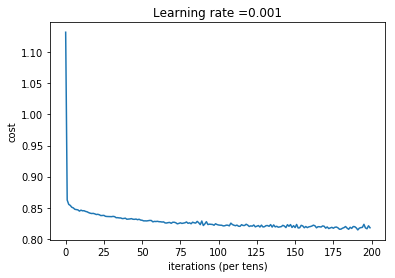

Parameters have been trained!

Train Accuracy: 0.61983335
Test Accuracy: 0.589



In [9]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [10]:
# print the result in two representations
print(str(len(pred_raus)) + " users predicted to be RAUs are:\n" + str(pred_raus))

print()

print("prospective_RAUs")
len_op=len(pred_raus)
for i in range(0, len_op):
    print("0"+str(pred_raus[i]))

0 users predicted to be RAUs are:
[]

prospective_RAUs
